# Neural Network Weight Optimisation Using Genetic Algorithms

## Tensorflow and PyGAD

### Importing Libararies

In [1]:
import sklearn
import pandas as pd
import pygad
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from pygad.kerasga import KerasGA

2023-04-05 22:05:21.542092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 22:05:22.091584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Configuring GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2023-04-05 22:05:22.585787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-04-05 22:05:22.585818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: shreya-Victus-by-HP-Laptop-16-e0xxx
2023-04-05 22:05:22.585827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: shreya-Victus-by-HP-Laptop-16-e0xxx
2023-04-05 22:05:22.586008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.85.12
2023-04-05 22:05:22.586023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.85.12
2023-04-05 22:05:22.586027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.85.12


In [3]:
df = pd.read_csv('processed_data.csv')

In [4]:
df = df.drop('Unnamed: 0',axis = 1)

In [5]:
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,target
0,25,1,49,4,1.6,1,0,1,0,0,0,0
1,45,19,34,3,1.5,1,0,1,0,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,1,0


In [6]:
df = pd.get_dummies(df,columns = ['Education'],drop_first = True)

### Loading and Preprocessing the Data

In [7]:
X = df.drop('target',axis = 1)
y = df['target']

In [8]:
len(X.columns)

12

### Splitting it into train and test and converting target into categorical data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    shuffle = True)

In [10]:
y_train=np_utils.to_categorical(y_train,num_classes=2)
y_test=np_utils.to_categorical(y_test,num_classes=2)

### Defining a basic tensorflow ANN 

In [11]:
model = Sequential([tf.keras.layers.Dense(12,input_shape = (12,),activation = 'relu'),
                    tf.keras.layers.Dense(8,activation = 'relu'),
                    tf.keras.layers.Dense(16, activation = 'relu'),
                    tf.keras.layers.Dense(8,activation = 'relu'),
                    tf.keras.layers.Dense(2,activation = 'softmax')
                   ])

In [12]:
model.compile(optimizer = 'adam', metrics = ['accuracy'],loss = 'categorical_crossentropy')

### Fitness function for the genetic algorithm

In [13]:
def fitness_func(solution, sol_idx):
    global X_train, y_train, keras_ga, model
    
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model = model,weights_vector = solution)
    
    model.set_weights(weights = model_weights_matrix)
    
    predictions = model.predict(X_train)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    solution_fitness = 1.0/(loss(y_train,predictions).numpy() + 0.0000000001)
    
    return solution_fitness

In [14]:
def callback_generation(ga_instance): #just prints the current generation number and the fitness value of the best solution in the current generation
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    #print('weights = {weights}'.format(weights= ga_instance.best_solution()[0]))

### Instantiating kerasGA

In [44]:
keras_ga = KerasGA(model = model, num_solutions = 5)

In [45]:
num_generations = 20
num_parents_mating = 4
initial_population = keras_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation,
                       parent_selection_type = 'rws',
                       
                       crossover_probability = 0.9,
                       mutation_type = 'random',
                       mutation_by_replacement = False,
                       #mutation_probability = 0.1,
                       mutation_percent_genes = 20,
                       random_mutation_min_val = -20,
                       random_mutation_max_val = 20,
                       #parallel_processing = ['thread', None],
                      random_seed = 8,
                      )

### Evolving through the generations

In [46]:
with tf.device('/device:GPU:0'):
     ga_instance.run()

92/92 [==============================] - 0s 499us/step
Generation = 1
92/92 [==============================] - 0s 512us/step
Fitness    = 0.9789232833445871
92/92 [==============================] - 0s 521us/step
Generation = 2
92/92 [==============================] - 0s 495us/step
Fitness    = 0.9789232833445871
92/92 [==============================] - 0s 434us/step
Generation = 3
92/92 [==============================] - 0s 523us/step
Fitness    = 0.9789232833445871
92/92 [==============================] - 0s 452us/step
Generation = 4
92/92 [==============================] - 0s 529us/step
Fitness    = 0.9789232833445871
92/92 [==============================] - 0s 479us/step
Generation = 5
92/92 [==============================] - 0s 510us/step
Fitness    = 0.9789232833445871
92/92 [==============================] - 0s 495us/step
Generation = 6
92/92 [==============================] - 0s 494us/step
Fitness    = 0.9789232833445871
92/92 [==============================] - 0s 596us/step
Gen

92/92 [==============================] - 0s 484us/step
Generation = 17
92/92 [==============================] - 0s 519us/step
Fitness    = 1.5292237297825624
92/92 [==============================] - 0s 563us/step
Generation = 18
92/92 [==============================] - 0s 510us/step
Fitness    = 1.5292237297825624
92/92 [==============================] - 0s 505us/step
Generation = 19
92/92 [==============================] - 0s 523us/step
Fitness    = 1.5292237297825624
92/92 [==============================] - 0s 532us/step
Generation = 20
92/92 [==============================] - 0s 473us/step
Fitness    = 1.5292237297825624


### Setting the best solution as the weights of the model and checking accuracy

In [47]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

92/92 [==============================] - 0s 523us/step
Fitness value of the best solution = 1.5292237297825624
Index of the best solution : 0


In [48]:
# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)
predictions = model.predict(X_train)
# print("Predictions : \n", predictions)

# Calculate the categorical crossentropy for the trained model.
cce = tf.keras.losses.CategoricalCrossentropy()
print("Categorical Crossentropy : ", cce(y_train, predictions).numpy())

# Calculate the classification accuracy for the trained model.

ca = tf.keras.metrics.CategoricalAccuracy()
ca.update_state(y_train, predictions)
accuracy = ca.result().numpy()
print("Accuracy : ", accuracy)

92/92 [==============================] - 0s 493us/step
Categorical Crossentropy :  0.65392655
Accuracy :  0.93662214


In [49]:
test_pred = model.predict(X_test)
ca.reset_states()
ca.update_state(y_test,test_pred)
accuracy = ca.result().numpy()
print("Testing Accuracy : ", accuracy)

45/45 [==============================] - 0s 529us/step
Testing Accuracy :  0.9437109


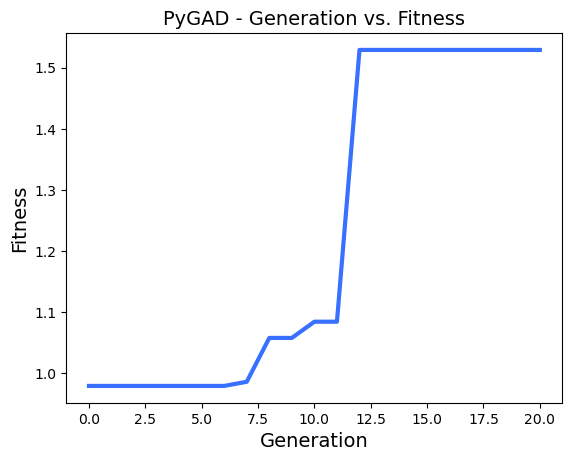

Figure(640x480)


In [51]:
print(ga_instance.plot_fitness())

### This model has the following parameters:

Number of Solutions = 5

Number of Parents = 4

Number of Generations = 20

It produces a model with a training accuracy of 93% and testing accuracy of 94%